# Hands-on session: Machine Learning & Data Visualization
---
## 2 - Fitting ML models
---


How do I use this?

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sina-mansour/OHBM-Brainhack-2021/blob/main/notebooks/02_model_fitting.ipynb) | [![View the notebook](https://img.shields.io/badge/render-nbviewer-orange.svg)](https://nbviewer.jupyter.org/github/sina-mansour/OHBM-Brainhack-2021/blob/main/notebooks/02_model_fitting.ipynb?flush_cache=true)

---

package installation for google colab:

In [ ]:
# install required packages for colab
!wget "https://raw.githubusercontent.com/sina-mansour/OHBM-Brainhack-2021/main/colab/requirements.txt" && pip install -r requirements.txt


---

Loading packages

In [1]:
# pandas for data handling
import pandas as pd

# matplotlib and seaborn for data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# setup inline plotting for jupyter
%matplotlib inline

# numpy for mathematical operations of data
import numpy as np

# nilearn and nibabel for handling neuroimaging data
import nilearn.datasets as nidata
import nilearn.plotting as niplot
import nibabel as nib

# sklearn is python's base of operations for everything ML
import sklearn

# statsmodels is more of an statistical inference toolbox for python
import statsmodels



---

## Train-Test splitting; data leakage!

Before we begin our journey of Machine learning, we need understand the very basic terminologies on **samples** and **features**. We also need to cover what we mean by train vs. test splitting, and how it should be implemented.

### Representation of Data in [Scikit-learn](https://github.com/scikit-learn/scikit-learn)

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a **two-dimensional array or matrix**. The arrays can be either ``numpy`` arrays, or pandas ``dataframe`` objects, or in some cases ``scipy.sparse`` matrices. The size of the array is expected to be `[n_samples, n_features]`

- **n_samples:**   The number of samples: each sample is an item to process (e.g. classify). A sample can be a document, a picture, a sound, a video, an astronomical object, a row in database or CSV file, or whatever you can describe with a fixed set of quantitative traits.
- **n_features:**  The number of features or distinct traits that can be used to describe each item in a quantitative manner.  Features are generally real-valued, but may be boolean or discrete-valued in some cases.

The number of features must be fixed in advance. However it can be very high dimensional (e.g. millions of features) with most of them being zeros for a given sample. This is a case where `scipy.sparse` matrices can be useful, in that they are much more memory-efficient than numpy arrays.

<img src="../static/image6.png" alt="Data Layout" style="width: 600px;"/>

(Figure from the [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook))

Now, let's try and extract the features matrix from the abide data for later use.

In [2]:
# load the data from file
data = pd.read_csv('https://raw.githubusercontent.com/sina-mansour/OHBM-Brainhack-2021/main/data/abide2.tsv', sep='\t')

# inspect the first few rows
data.head()


,site,subject,age,age_resid,sex,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,ABIDEII-KKI_1,29293,8.893151,13.642852,2.0,1.0,2750.0,306.0,354.0,2123.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,ABIDEII-OHSU_1,28997,12.000000,16.081732,2.0,1.0,2836.0,186.0,354.0,2261.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,ABIDEII-GU_1,28845,8.390000,12.866264,1.0,2.0,3394.0,223.0,373.0,2827.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,ABIDEII-NYU_1,29210,8.300000,13.698139,1.0,1.0,3382.0,266.0,422.0,2686.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,ABIDEII-EMC_1,29894,7.772758,14.772459,2.0,2.0,3080.0,161.0,346.0,2105.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


We aim to use the brain data as the training feature set:

In [3]:
# The filter() method allows us to select variables by name--
# in this case, we put all features that match 'fs' in X_all.
X_all = data.filter(like='fs')

X_all.head()

,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,fsArea_L_V8_ROI,fsArea_L_4_ROI,fsArea_L_3b_ROI,fsArea_L_FEF_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,2750.0,306.0,354.0,2123.0,1451.0,1128.0,269.0,1751.0,1338.0,632.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,2836.0,186.0,354.0,2261.0,1584.0,1241.0,259.0,1521.0,1105.0,302.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,3394.0,223.0,373.0,2827.0,1816.0,1299.0,221.0,1657.0,1374.0,456.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,3382.0,266.0,422.0,2686.0,1893.0,1359.0,234.0,1889.0,1545.0,407.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,3080.0,161.0,346.0,2105.0,1307.0,1004.0,254.0,1334.0,985.0,315.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


In [4]:
# for the sake of simplicity we'll only use a portion of the whole feature set
N_FEATURES = 5

# pandas DFs have a helpful sample() method for sampling rows/columns
X_sample = X_all.sample(N_FEATURES, axis=1, random_state=100)

X_sample.head()

,fsCT_R_a24_ROI,fsArea_R_d32_ROI,fsCT_L_PBelt_ROI,fsLGI_L_POS2_ROI,fsVol_L_FOP1_ROI
0,3.392,358.0,2.564,641.23,434.0
1,3.548,302.0,2.673,715.53,585.0
2,2.834,581.0,2.939,708.54,519.0
3,2.940,473.0,2.437,828.24,646.0
4,3.859,435.0,2.852,812.84,662.0


### Train-Test Splitting

The train-test split is a technique for evaluating the performance of a machine learning algorithm. It's a method that is mainly used for evaluation of supervised learning tasks.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the **training dataset**. The second subset is *not used to train the model*. In fact, it should be left untouched and unseen. This subset will be used to investigate the performance of the predictions. This second dataset is referred to as the test dataset.

- Train Dataset: Used to fit the machine learning model.
- Test Dataset: Used to evaluate the model fit.

<img src="../static/image7.png" alt="Split structure" style="width: 900px;"/>


#### Data leakage in machine learning

Data leakage is a big problem in machine learning when developing predictive models. Data leakage is a term used to refer to when information from outside the training dataset (usually from the test dataset) is used for model fitting. Data leakage generally results in inflated performance evaluation.



Let's do the train-test splitting from the beginning so that we're sure, there will be no data leakage. (We will not use the test split until evaluation steps.)

In [5]:
# A fixed random seed for reproducibility
split_random_seed = 123

# Split feature set
X_sample_train, X_sample_test = sklearn.model_selection.train_test_split(X_sample, test_size=200, random_state=split_random_seed)
X_all_train, X_all_test = sklearn.model_selection.train_test_split(X_all, test_size=200, random_state=split_random_seed)

# Let's ensure sizes are valid
print(f'Train dataset shape: {X_sample_train.shape}\nTest dataset shape: {X_sample_test.shape}')


Train dataset shape: (804, 5)
Test dataset shape: (200, 5)


In [6]:
# Split the demographic information for later
age = data['age']
sex = data['sex']
group = data['group']

age_train, age_test = sklearn.model_selection.train_test_split(age, test_size=200, random_state=split_random_seed)
sex_train, sex_test = sklearn.model_selection.train_test_split(sex, test_size=200, random_state=split_random_seed)
group_train, group_test = sklearn.model_selection.train_test_split(group, test_size=200, random_state=split_random_seed)


---
## Estimators and cost functions

### Estimators in scikit-learn: Basic usage
One of scikit-learn's most attractive features is its unified, simple interface for configuring estimators and fitting models. A good deal of the package consists of a very large set of `Estimator` classes you can use to do various forms of machine learning. In scikit-learn, an `Estimator` does exactly what the word *estimator* normally means in statistics: it implements ["a rule for calculating an estimate of a given quantity based on observed data"](https://en.wikipedia.org/wiki/Estimator).

While scikit-learn includes hundreds of different estimators that generate predictions in very different ways, they all share a common interface (or *API*). In particular, every estimator class implements `.fit()` and `.predict()` methods. When we call an estimator's `.fit()` method, we're telling it to take some training data—including a mandatory `X` matrix, and an optional `y` vector (if it's a supervised estimator)—and do something with it. In cases where `y` is present, the estimator is generally trying to learn how to predict the values of `y` from the values in `X`. Once it's done that, we can then call `predict()`, which takes another `X` matrix (either the same one as before, or a different one) and predicts corresponding `y` scores.

A list of various estimators available through sklearn can be found [here](https://scikit-learn.org/stable/modules/classes.html). Selecting the appropriate estimator is a key step, and it usually creates a large degree of freedom for the researcher. Usually, prior knowledge about the features can help in choosing the estimator. However, some general rule of thumb recommendations exist too:

<img src="../static/image8.png" alt="Estimator selection" style="width: 900px;"/>

(Figure from the [Sci-Kit learn's machine learning tutorial](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html))


---
## Regression estimators

As explained previously, regression is a supervised learning approch to predict continuous data, i.e. the train dataset is used to learn the relationship between the feature set and a variable of interest.

A regression problem arises any time we have a set of continuous numerical labels, and we're interested in using one or more features to try and predict those labels. Any bivariate relationship can be conceptualized as a regression of one variable on the other. For example, suppose we have the data displayed in this scatterplot:

Text(0, 0.5, 'y')

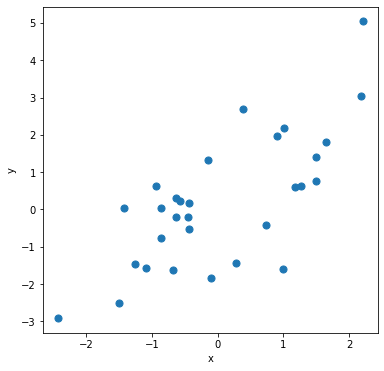

In [7]:
# fix seed to produce deterministic results
np.random.seed(123)

x = np.random.normal(size=30)
y = x * 1.2 + np.random.normal(size=30)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(x, y, s=50)
plt.xlabel('x')
plt.ylabel('y')


We can frame this as a regression problem by saying that our goal is to generate the best possible prediction for `y` given knowledge of `x`.

For instance, we can try to find a *linear* relationship that can predict y from x:

Text(0, 0.5, 'y')

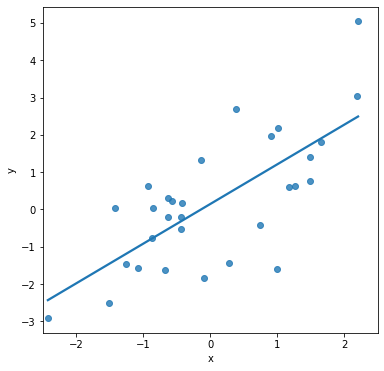

In [8]:
# fix seed to produce deterministic results
np.random.seed(123)

x = np.random.normal(size=30)
y = x * 1.2 + np.random.normal(size=30)

fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(data=pd.DataFrame(np.array([x,y]).T, columns=['x','y']), x='x', y='y', ax=ax, ci=None)
ax.set_xlim([-2.5,2.5])
plt.xlabel('x')
plt.ylabel('y')


In our data, we are interested in predicting age from brain data. This concept is formally known as brain-age prediction.

We can see how a measure of cortical thickness changes by age:

<AxesSubplot:xlabel='age', ylabel='fsVol_L_FOP1_ROI'>

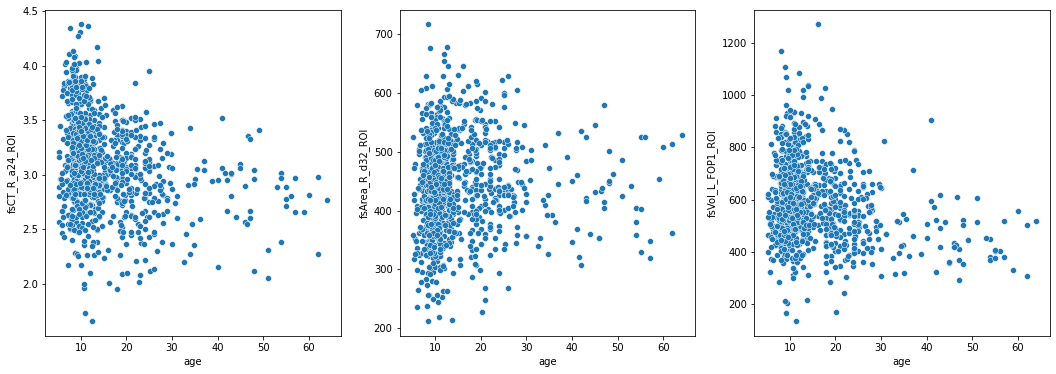

In [9]:
# create a figure
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

# scatter brain data vs. age
sns.scatterplot(y=data['fsCT_R_a24_ROI'], x=data['age'], ax=axes[0])
sns.scatterplot(y=data['fsArea_R_d32_ROI'], x=data['age'], ax=axes[1])
sns.scatterplot(y=data['fsVol_L_FOP1_ROI'], x=data['age'], ax=axes[2])


The relationship is not as clear as it is with simulated data. However, we hope that we could exploit the capabilities of machine learning to predict an individual's age from a collective of brain information.

Let's start with a simple model, and see how it goes:

### Applying the LinearRegression() estimator
To see this in action, let's try out one particular estimator in scikit-learn: "ordinary" least-squares (OLS) regression.



In [10]:
# initialize the estimator
model = sklearn.linear_model.LinearRegression()

# Fit a regression model to predict age from cortical information
model.fit(X_sample_train, age_train)


LinearRegression()

Once we execute the above line, we have a fitted model. One thing we can do at this point is examine the estimated model parameters:

In [11]:
# The sklearn convention is to denote fitted parameters with a trailing underscore
print("Estimated intercept:", model.intercept_.round(2))
print("Estimated coefficients:", model.coef_.round(2))

Estimated intercept: 57.58
Estimated coefficients: [-4.35  0.01 -9.49 -0.   -0.01]


Notice that the coefficients vary dramatically in size. This isn't because 2 of them are much more important than the other 3; it's because the sets of FreeSurfer features are on very different scales (e.g., the surface area features have much larger values than the cortical thickness features). 

Later in the tutorial, we'll cover how to standardize the features so they're all on the same scale.

Now that we've fitted a model, we need to use this model on the test sample for prediction. We can make use of the `.predict()` method that all supervised scikit-learn estimators implement.

In [12]:
# use predict to compute the age for test subjects
age_test_predicted = model.predict(X_sample_test)


In the next module we'll cover how to evaluate the goodness of the fit and the accuracy of the predictions. But, for now, let's compare the predictions against the actual age values to get a sense of what our model achieved:


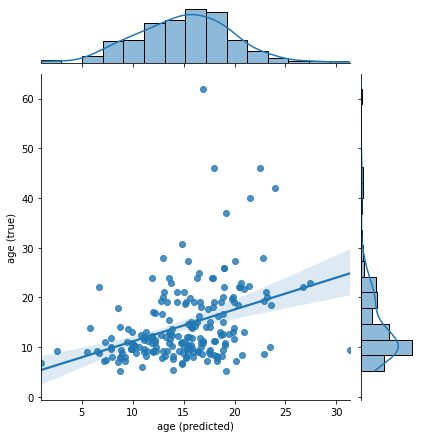

In [13]:
# create a figure
# fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

# scatter brain data vs. age
fig = sns.jointplot(x=age_test_predicted, y=age_test, kind="reg", ax=ax)
fig.set_axis_labels("age (predicted)", "age (true)")

What's interesting is that although this was a very simplified model, we can see that it was able to capture some information about the relationship between age and cortical properties extracted from freesurfer.

And what's more, this model was created from only 3 lines of code:

- one to initialize an estimatore
- one to fit the model
- and one to predict

This simple design is helpful as it facilitates implementation of more complicated models. Due to it's simplicity, the sklearn code base can be used to generalize the idea of fitting a machine learning model.

As a practice we could try and implement a different model:

In [14]:
# initialize the estimator
model = sklearn.svm.SVR()

# Fit a regression model to predict age from cortical information
model.fit(X_sample_train, age_train)

# use predict to compute the age for test subjects
age_test_predicted = model.predict(X_sample_test)


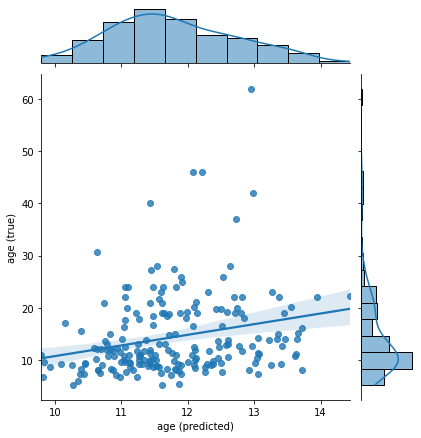

In [15]:
# create a figure
# fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

# scatter brain data vs. age
fig = sns.jointplot(x=age_test_predicted, y=age_test, kind="reg", ax=ax)
fig.set_axis_labels("age (predicted)", "age (true)")

We can see that the two models are predicting differently and we'd require evaluation metrics to compare the performances of these different models.

Although fitting more advanced models could be as simple as the few lines above, in order to truly use the benefits of such methods, other steps such as parameter tuning are necessary. These concepts will be further covered in the best practices section.

---
## Classification estimators

As previously mentioned, classification is a supervised discrete learning where the feature space is used to predict distinct labels. In classification, just like in regression, we're still trying to learn to make the best predictions we can with respect to some target set of labels. The difference is that the labels are now discrete rather than continuous. In the simplest case, the labels are binary: there are only two *classes*. For example, we might have data that look like this:


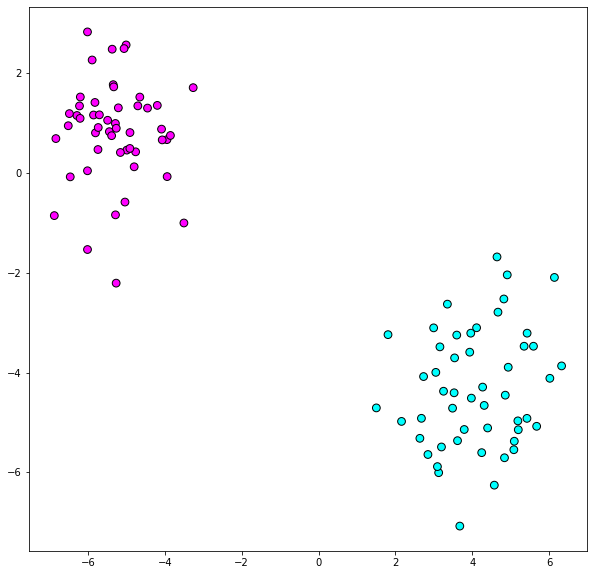

In [16]:
# scikit-learn has some handy utilities for generating structured data
from sklearn.datasets import make_blobs

X_, y_ = make_blobs(centers=2, random_state=123)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(*X_.T, c=y_, s=60, edgecolor='k', linewidth=1, cmap='cool');


Here, we have two features (on the x- and y-axes) we can use to try to correctly *classify* each sample. The two classes are labeled by color.

In the above example, the classification problem is quite trivial: it's clear to the eye that the two classes are perfectly *linearly separable*, so that we can correctly classify 100% of the samples just by drawing a line between them.

Unfortunately, few real-world problems are rarely this simple. If they were, machine learning wouldn't be its own field of study, and employers wouldn't be falling over themselves to pay exorbitant salaries to people who are good at putting circles into boxes of the right color.

Here's what a more realistic classification problem in two dimensions might look like:

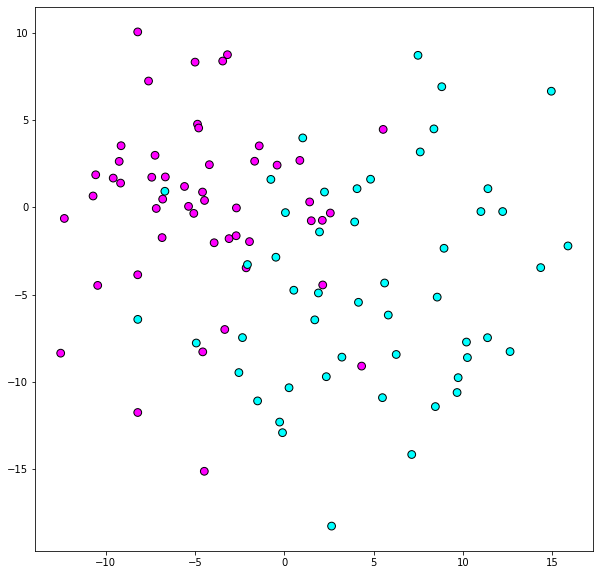

In [17]:
# scikit-learn has some handy utilities for generating structured data
from sklearn.datasets import make_blobs

X_, y_ = make_blobs(centers=2, random_state=123, cluster_std=5)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(*X_.T, c=y_, s=60, edgecolor='k', linewidth=1, cmap='cool');


Not so easy now, is it? In fact, it's entirely possible that there's no feasible way to perfectly discriminate between the two classes (i.e., even the best possible classifier we could train would always suffer from some degree of misclassification).

Most real-world supervised learning problems—whether they involve regression or classification—have far more than two features we can use to generate predictions, so the complexity of the problem is much greater than the above suggests. Moreover, classification problems aren't restricted to just two classes. For example, we could have a multiclass classification problem like this, where our goal is still to correctly label each point, but now there are 5 possible classes:

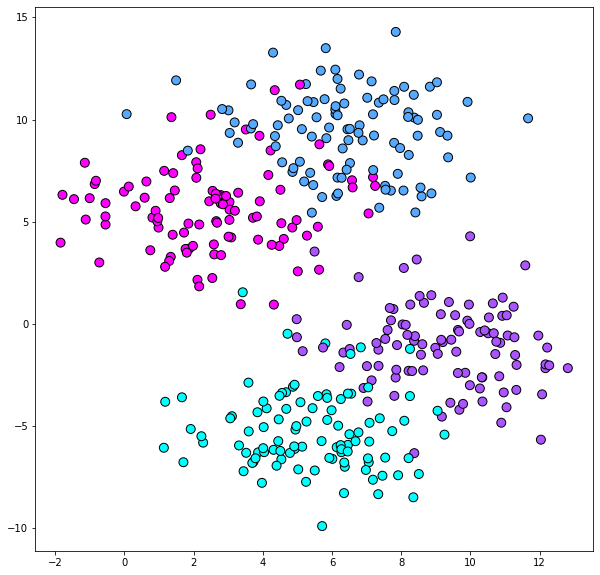

In [18]:
# scikit-learn has some handy utilities for generating structured data
from sklearn.datasets import make_blobs

X_, y_ = make_blobs(400, centers=4, random_state=13, cluster_std=2)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(*X_.T, c=y_, s=80, edgecolor='k', linewidth=1, cmap='cool');


In this case, the target labels we're trying to predict are discrete. Fortunately, the information about the diagnosis group can be used to fit a classification which learns the relationship between cortical properties and diagnosis. Recall that ABIDE II is an autism project, and roughly half of the participants in the dataset are diagnosed with autism. So let's see if we can predict autism diagnosis, rather than age, from structural brain features.

Text(0.5, 0, 'fsCT_L_PBelt_ROI')

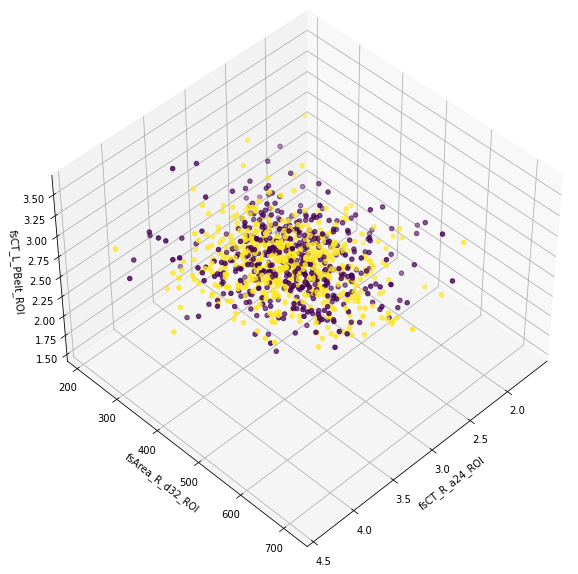

In [19]:
# X_sample.T[:3].T.shape
x, y, z = X_sample.T[:3].T

# X_sample[y]
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='3d'))

ax.scatter(X_sample[x], X_sample[y], X_sample[z], marker='o', c=group)
ax.view_init(45,45)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)


### Applying classifiers
Okay, let's get on with the actual classification. How do we apply classification estimators in scikit-learn? It's a trick question! We've actually already covered it in the regression example. For the most part, there's very little difference in the way we interact with regression and classification estimators; we just have to be careful not to pass discrete labels to regression estimators, or continuous labels to classification estimators. But mechanically, we construct and fit the models in the same way.

Let's try this out with a *gaussian Naive Bayes* (GNB) classifier. [Gaussian Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Gaussian_na%C3%AFve_Bayes) is a simple classification approach based on a "naive" application of Bayes' Theorem (the naivete stems from the classifier's assumption that all features are independent of one another conditional on class assignment—an assumption that greatly simplifies analysis, though it's nearly always false). It's a good baseline estimator, because it performs surprisingly well in many situations, and is extremely computationally efficient.

Naive Bayes classifiers have no trouble handling large sets of highly correlated features, so we'll just throw everything we have at the classifier, and try to predict diagnosis class from all 1,440 features.

In [20]:
from sklearn.naive_bayes import GaussianNB

# Initialize naive bayes classifier
gnb = GaussianNB()

# fit the model
gnb.fit(X_all_train, group_train)



GaussianNB()

To get a sense of how well the model performed, we could use the in-built score function (this will be covered in more detail in the next section.)

In [21]:
gnb.score(X_all_train, group_train)

0.6380597014925373

In [22]:
gnb.score(X_all_test, group_test)

0.585

---
## Clustering estimators

In clustering, our goal is to label the samples we have into discrete *clusters* (or groups). In a sense, clustering is just *classification without ground truth*. In classification, we're trying to recover the class assignments that we know to be there; in clustering, we're trying to make class assignments even though we have no idea what the classes truly are, or even if they exist at all.

The best-case scenario for clustering would be something like this:

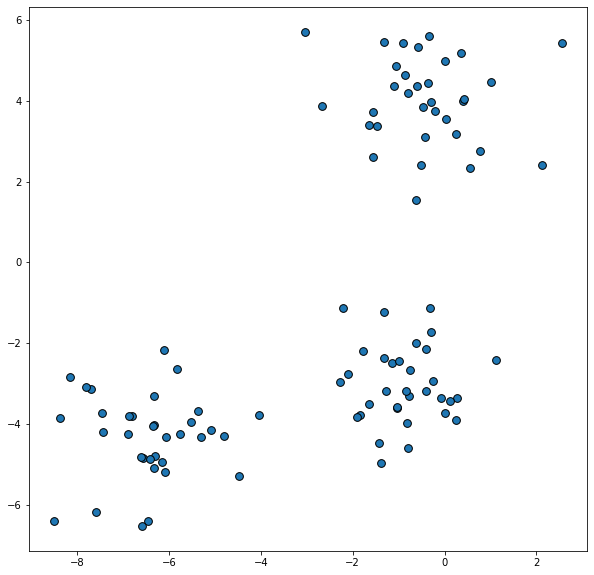

In [162]:
# scikit-learn has some handy utilities for generating structured data
from sklearn.datasets import make_blobs

X_, y_ = make_blobs(centers=3, random_state=1323, cluster_std=1)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(*X_.T, s=60, edgecolor='k', linewidth=1, cmap='cool');


As we don't know the true labels for these observations, any cluster assignment we come up with is just our best guess as to what might be going on. Nevertheless, in this particular case, the spatial grouping of the samples in 2 dimensions is so striking that it's hard to imagine us having any confidence in any assignment except the following one:

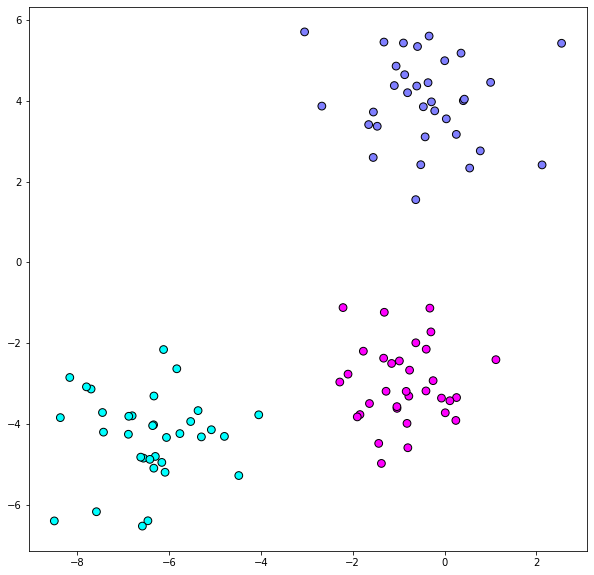

In [163]:
# scikit-learn has some handy utilities for generating structured data
from sklearn.datasets import make_blobs

X_, y_ = make_blobs(centers=3, random_state=1323, cluster_std=1)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(*X_.T, c=y_, s=60, edgecolor='k', linewidth=1, cmap='cool');


Unfortunately for us, just as we don't often get super clean classification or regression problems, clustering problems as easy as the one above are rare. A more typical scenario might look something like this:

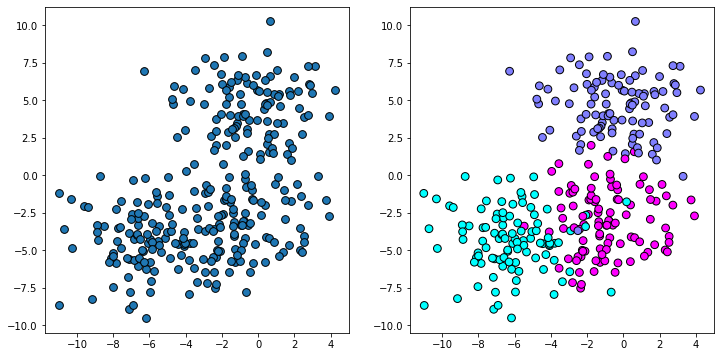

In [170]:
# scikit-learn has some handy utilities for generating structured data
from sklearn.datasets import make_blobs

X_, y_ = make_blobs(300, centers=3, random_state=1323, cluster_std=2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(*X_.T, s=60, edgecolor='k', linewidth=1, cmap='cool');
axes[1].scatter(*X_.T, c=y_, s=60, edgecolor='k', linewidth=1, cmap='cool');


## Clustering example: neural subtype of autism

Clustering applications are common in psychiatry and psychiatric imaging, as researchers often want to determine whether, e.g., patients with a particular diagnosis appear to cluster into somewhat distinct subtypes—with potential implications for prognosis, treatment, etc.

We can ask this question with respect to the ABIDE data we have available. If we take only those subjects with an autism diagnosis, can we cluster subjects into discrete subtypes based on differences in the brain features we have available?

scikit-learn contains implementations of quite a few popular clustering algorithms. Clustering estimators in sklearn are located in the `sklearn.cluster` module. We'll focus our attention on what is arguably the most widely used clustering algorithm, namely, *k*-means. In *k*-means clustering, we assign samples to *k* discrete clusters in such a way as to minimize the distance from each observation to the centroid of the cluster it belongs to, and maximize the distance between the cluster centroids. We won't get into the [details of the k-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) here; instead, we simply want to demonstrate how to run a cluster analysis with scikit-learn.

As you might expect by now, our code will look a lot like it did for regression and classification. In principle, we could use all 1,440 features if we wanted to (though computation would likely be slow). But the unsupervised nature of clustering means that evaluating clustering solutions in high dimensions can be quite difficult. So let's focus on clustering observations in just 2 dimensions, and if after that you want to crank up the number of features, you can easily do that.

These first few lines of code are just to get our `X` data: we select only the subjects with an autism diagnosis; then we randomly sample two of our brain features; lastly, we standardize those features to ensure that the k-means algorithm weights them approximately equally (*k*-means computes distances between observations in euclidian space, so differences in scale will bias the clustering).

In [23]:
# the preprocessing module contains a bunch of useful utilities.
# in this case we're going to standardize our columns (i.e.,
# to transform them so they have a mean of 0 and variance of 1).
from sklearn.preprocessing import scale

# we'll be using only 2 cortical features for simplicity, feel free to change this
N_FEATURES = 2

# identify indices of the subjects with autism
aut_grp = data['group'] == 1

# get 2 random brain features. note that the random_state is
# fixed; remove it to re-randomize each time.
dx_1 = X_all[aut_grp].sample(2, axis=1, random_state=1234)

# save selected column names for display later
columns = dx_1.columns

# standardize columns, otherwise k-means will likely
# weight one feature much more than the other
dx_1 = scale(dx_1)

The actual clustering is, as usual, just a couple of lines of code:

In [24]:
# We'll use KMeans here, but feel free to experiment with
# others—though note that many of the implemented clustering
# algorithms will be very slow if you crank up the number
# of features.
from sklearn.cluster import KMeans

# We have to stipulate the number of features in advance
K = 3

# Initialize the estimator
km = KMeans(K)

# Fit and predict in one shot
clusters = km.fit_predict(dx_1)

Notice that the main difference between the clustering code compared to the classification example is that we're no longer passing in the array of labels `y`. We're just trying to find meaningful structure in the data, with no access to any ground truth.

Also notice that we need to specify the number of clusters *k* ourselves. There are literally hundreds of methods people have developed to try to identify the "optimal" value of *k*, and some of them are included in the `sklearn.metrics` module. But for our purposes, let's just focus on the solution we get for $k = 3$. 

We can use the `clusters` array of labels by calling `.predict()` on a clustering estimator (indexing from 0 for the first cluster):

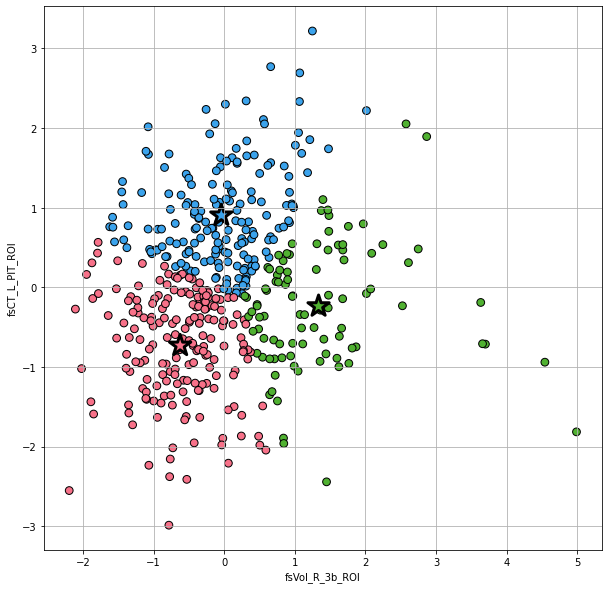

In [25]:
# get nice colors from seaborn
palette = sns.husl_palette(K)
colors = [palette[c] for c in clusters]

# create single subplot
fig, ax = plt.subplots(figsize=(10, 10))

# plot labeled 
plt.scatter(dx_1[:, 0], dx_1[:, 1], c=colors, edgecolor='k', s=60)

# add cluster centers in black
plt.scatter(*km.cluster_centers_.T, c=palette, edgecolor='k', linewidth=3, s=500, marker='*')
plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.grid(None)

The clustering may *look* reasonable to the eye, but how far should we really trust it? And how should we think about these cluster labels? Are they merely convenient descriptions of the data that facilitate exploration of differences between subgroups of participants, or do we think we're gaining deep insights into the "true" neural bases of different subtypes of autism? Or is it only the case that we are torturing our data for information?

---
## Dimensionality reduction estimators


As mentioned unsupervised learning addresses a different sort of problem. Where the data has no labels, and we are interested in finding patterns between the objects in question. In a sense, you can think of unsupervised learning as a means of discovering labels from the data itself.

### Dimensionality Reduction with PCA

Principle Component Analysis (PCA) is a dimensionality reduction technique that can find the combinations of variables that explain the most variance. Consider the freesurfer cortical data. It cannot be visualized in a single 2D plot, as it has many cortical features.

Can we extend the idea of neural subtyping intto a continuous case of dimensionality reduction where the cortical measures are first summarized into a few dimensions. We could then use those dimensions of maximal variance and investigate how they change with age.


For this purpose we'll first summarize all features of cortical thickness into 2 dimensions and then investigate it's change across aging:

In [26]:
# The filter() method allows us to select variables by name--
X_cortical_thickness = X_all.filter(like='fsCT_')

X_cortical_thickness.head()

,fsCT_L_V1_ROI,fsCT_L_MST_ROI,fsCT_L_V6_ROI,fsCT_L_V2_ROI,fsCT_L_V3_ROI,fsCT_L_V4_ROI,fsCT_L_V8_ROI,fsCT_L_4_ROI,fsCT_L_3b_ROI,fsCT_L_FEF_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,1.971,2.827,1.816,2.062,2.008,2.248,3.352,2.384,2.016,2.322,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,1.915,2.708,2.145,2.134,2.322,2.526,2.797,2.874,1.640,2.535,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,1.748,2.162,2.332,2.061,2.342,2.358,2.547,2.652,1.663,2.523,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,2.096,2.780,2.355,2.270,2.424,2.530,2.916,2.621,1.593,2.399,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,2.129,2.223,2.275,2.296,2.187,2.086,2.965,2.484,2.018,2.071,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


Now we'll use dimensionality reduction to reduce this data to the first two dimension of maximal variance. As you may have guessed, `sklearn.decomposition` hosts a collection of various dimensionality reduction methods.

Similarly, it is only a few lines of code to fit the dimensionality reduction estimator:

In [27]:
# We'll be using a very basic but practical dimensionality reduction method: PCA
# feel free to try other dimensionality reduction methods
from sklearn.decomposition import PCA

# We will only extract a single component
pca = PCA(n_components=2)

# fit the model
pca.fit(X_cortical_thickness.T)


PCA(n_components=2)

Text(0.5, 0, 'age')

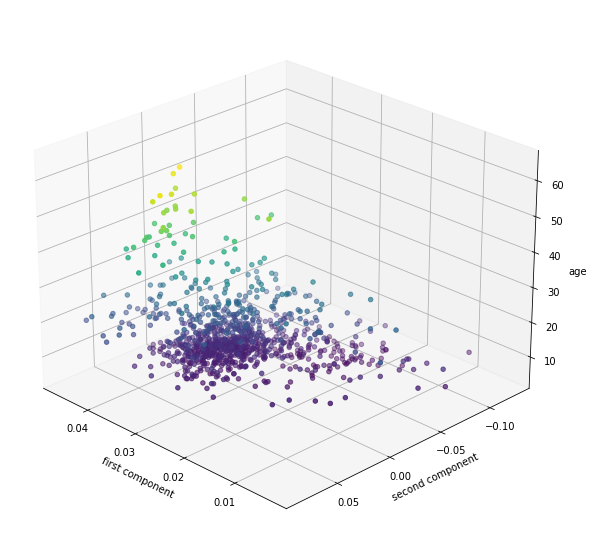

In [28]:
# create a figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='3d'))

# scatter cortical components vs. age
ax.scatter(pca.components_[0], pca.components_[1], age, marker='o', c=age)
ax.view_init(25,135)
ax.set_xlabel('first component')
ax.set_ylabel('second component')
ax.set_zlabel('age')


## Where we got?
At this point, let's sit back and assess our progress. We've developed fully operational machine learning workflows for regression, classification, clustering and dimensionality reduction. Thanks to scikit-learn, all three involved very little work. In each case, it took only a few lines of code to initialize a model, fit it to some data, and use it to generate predictions or clustering labels. This all seems pretty great.


Now that we're familiarized with the basics of fitting machine learning models, the next step down the line is to learn how to evaluate the created models. As you may have very well figured out by now, sklearn, again, has got us covered. Most evaluation metrics we need are allready implemented in the package and can be invoked in a couple of lines of codes. In the next section, we'll go over some of the common evaluation measures used in the machine learning models.